## Tugas 4

In [ ]:
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import nltk
import re
import joblib

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/pramdf042/PPW/main/crawling_viva_fix.csv')
df

,Judul,Isi Berita,Link,Kategori
0,Terpopuler: Tentara Israel Frustasi Dihujat Wa...,Round Up – Perang Israel-Hamas di Jalur Gaza t...,https://www.viva.co.id/berita/nasional/1660151...,nasional
1,"Jadi Tersangka Pemerasan, Firli Bahuri Teranca...",Jakarta - Ketua Komisi Pemberantasan Korupsi (...,https://www.viva.co.id/berita/nasional/1660272...,nasional
2,"Firli Bahuri Ditetapkan Tersangka, Eks Pegawai...",Jakarta – Ketua wadah pegawai KPK Yudi Purnomo...,https://www.viva.co.id/berita/nasional/1660271...,nasional
3,Kondisi Terkini 4 Korban Luka Kecelakaan Minib...,Surabaya – Empat korban luka berat dalam insid...,https://www.viva.co.id/berita/nasional/1660237...,nasional
4,Polisi Segera Periksa Firli sebagai Tersangka ...,Jakarta- Polisi segera mengagendakan pemeriksa...,https://www.viva.co.id/berita/nasional/1660268...,nasional
...,...,...,...,...
67,Firli Bahuri Resmi Jadi Tersangka Kasus Pemera...,Jakarta – Polda Metro Jaya menetapkan Ketua Ko...,https://www.viva.co.id/berita/nasional/1660262...,kriminal
68,"Jadi Tersangka Pemerasan, Firli Bahuri Teranca...",Jakarta - Ketua Komisi Pemberantasan Korupsi (...,https://www.viva.co.id/berita/nasional/1660272...,kriminal
69,Kronologi Lengkap Kasus Mutilasi Mahasiswa UMY,Yogyakarta – Dua terdakwa kasus mutilasi terha...,https://www.viva.co.id/berita/kriminal/1660261...,kriminal
70,"Firli Bahuri Ditetapkan Tersangka, Eks Pegawai...",Jakarta – Ketua wadah pegawai KPK Yudi Purnomo...,https://www.viva.co.id/berita/nasional/1660271...,kriminal


In [ ]:
df.isnull().sum()

Judul         0
Isi Berita    0
Link          0
Kategori      0
dtype: int64

In [ ]:
df = df.dropna()
df.isnull().sum()

Judul         0
Isi Berita    0
Link          0
Kategori      0
dtype: int64

In [ ]:
df.shape

(72, 4)

In [ ]:
def cleaning(text):
  text = re.sub(r'[^\w\s.?!,]', '', text).strip()
  return text

df['Cleaning'] = df['Isi Berita'].apply(cleaning)
df['Cleaning']

0     Round Up  Perang IsraelHamas di Jalur Gaza ter...
1     Jakarta  Ketua Komisi Pemberantasan Korupsi KP...
2     Jakarta  Ketua wadah pegawai KPK Yudi Purnomo ...
3     Surabaya  Empat korban luka berat dalam inside...
4     Jakarta Polisi segera mengagendakan pemeriksaa...
                            ...                        
67    Jakarta  Polda Metro Jaya menetapkan Ketua Kom...
68    Jakarta  Ketua Komisi Pemberantasan Korupsi KP...
69    Yogyakarta  Dua terdakwa kasus mutilasi terhad...
70    Jakarta  Ketua wadah pegawai KPK Yudi Purnomo ...
71    Pasuruan  Seorang Caleg muda PKB Kabupaten Pas...
Name: Cleaning, Length: 72, dtype: object

In [ ]:
def tokenizer(text):
  text = text.lower()
  return sent_tokenize(text)

df['Tokenizing'] = df['Cleaning'].apply(tokenizer)
df['Tokenizing']

0     [round up  perang israelhamas di jalur gaza te...
1     [jakarta  ketua komisi pemberantasan korupsi k...
2     [jakarta  ketua wadah pegawai kpk yudi purnomo...
3     [surabaya  empat korban luka berat dalam insid...
4     [jakarta polisi segera mengagendakan pemeriksa...
                            ...                        
67    [jakarta  polda metro jaya menetapkan ketua ko...
68    [jakarta  ketua komisi pemberantasan korupsi k...
69    [yogyakarta  dua terdakwa kasus mutilasi terha...
70    [jakarta  ketua wadah pegawai kpk yudi purnomo...
71    [pasuruan  seorang caleg muda pkb kabupaten pa...
Name: Tokenizing, Length: 72, dtype: object

In [ ]:
def graph_cosine_sim(x, threshold = 0.11):
  # TFIDF
  vectorizer = TfidfVectorizer()
  tfidf = vectorizer.fit_transform(x)
  cos_sim = cosine_similarity(tfidf)
  G = nx.Graph()

  # Mengisi nilai similarity antara kalimat ke dalam edges (Garis Penghubung)
  for i in range(len(x)):
    for j in range(i+1, len(x)):
      sim = cos_sim[i][j]
      if sim > threshold:
        G.add_edge(i, j, weight=sim)

  return G

In [ ]:
def plot_graph(G, figsize=(35, 30), node_size=700, node_color='skyblue'):
  # Menggambar graf dengan canvas yang diperbesar
  pos = nx.spring_layout(G)  # Menentukan posisi simpul
  labels = nx.get_edge_attributes(G, 'weight')

  # Menentukan ukuran canvas
  plt.figure(figsize=(35, 30))

  # Menggambar graf dengan ukuran canvas yang diperbesar
  nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')
  plt.show()

In [ ]:
def summarization(x, k = 4, index=1, threshold=0.11, show_centrality=False):
  # Memasukkan Nilai Cosine Similirity ke dalam Graph
  G = graph_cosine_sim(x, threshold)

  # Menghitung nilai dari closeness centrality
  centrality = nx.closeness_centrality(G)
  if show_centrality:
    print(f"Nilai Closeness Centrality Dokumen Ke - {index} : {centrality}")

  # Menyusun Kalimat berdasarkan nilai Closeness Centrality tertinggi dan lebih dari treshold
  centrality = dict(sorted(centrality.items(), key=lambda item : item[1], reverse=True))

  summary_sentences = []
  for i, centr in enumerate(centrality.items()):
    if i < k:
      summary_sentences.append(x[centr[0]])

  return (' '.join(summary_sentences).split('\n'), G)

In [ ]:
summary, G = summarization(df["Tokenizing"].iloc[:1][0], k = 5, show_centrality=True, threshold=0.2)

Nilai Closeness Centrality Dokumen Ke - 1 : {0: 0.16666666666666666, 3: 0.25, 4: 0.16666666666666666, 10: 0.3125, 18: 0.5208333333333334, 12: 0.390625, 13: 0.2604166666666667, 14: 0.3125, 16: 0.3125}


In [ ]:
summary

['selengkapnya di tautan ini selengkapnya di tautan ini',
 'dua bocah yang masih duduk di sekolah dasar asal kabupaten sampang, madura, nekat mengendarai sepeda motor ke jakarta. selengkapnya di tautan ini',
 'koordinator masyarakat anti korupsi maki boyamin saiman menyebutkan kalau ketua kpk firli bahuri berbohong ketika dirinya menjelaskan mobilnya hilang saat rampung menjalani pemeriksaan di bareskrim polri. selengkapnya di tautan ini',
 'perdebatan sengit terjadi dengan melibatkan poliitkus pdi perjuangan pdip guntur romli dengan pengamat sekaligus direktur eksekutif indo barometer m. qodari. selengkapnya di tautan ini',
 'pasangan capres dan cawapres nomor urut 1, anies baswdanmuhaimin iskandar amin kembali mengumumkan formasi timnas pemenangannya.']

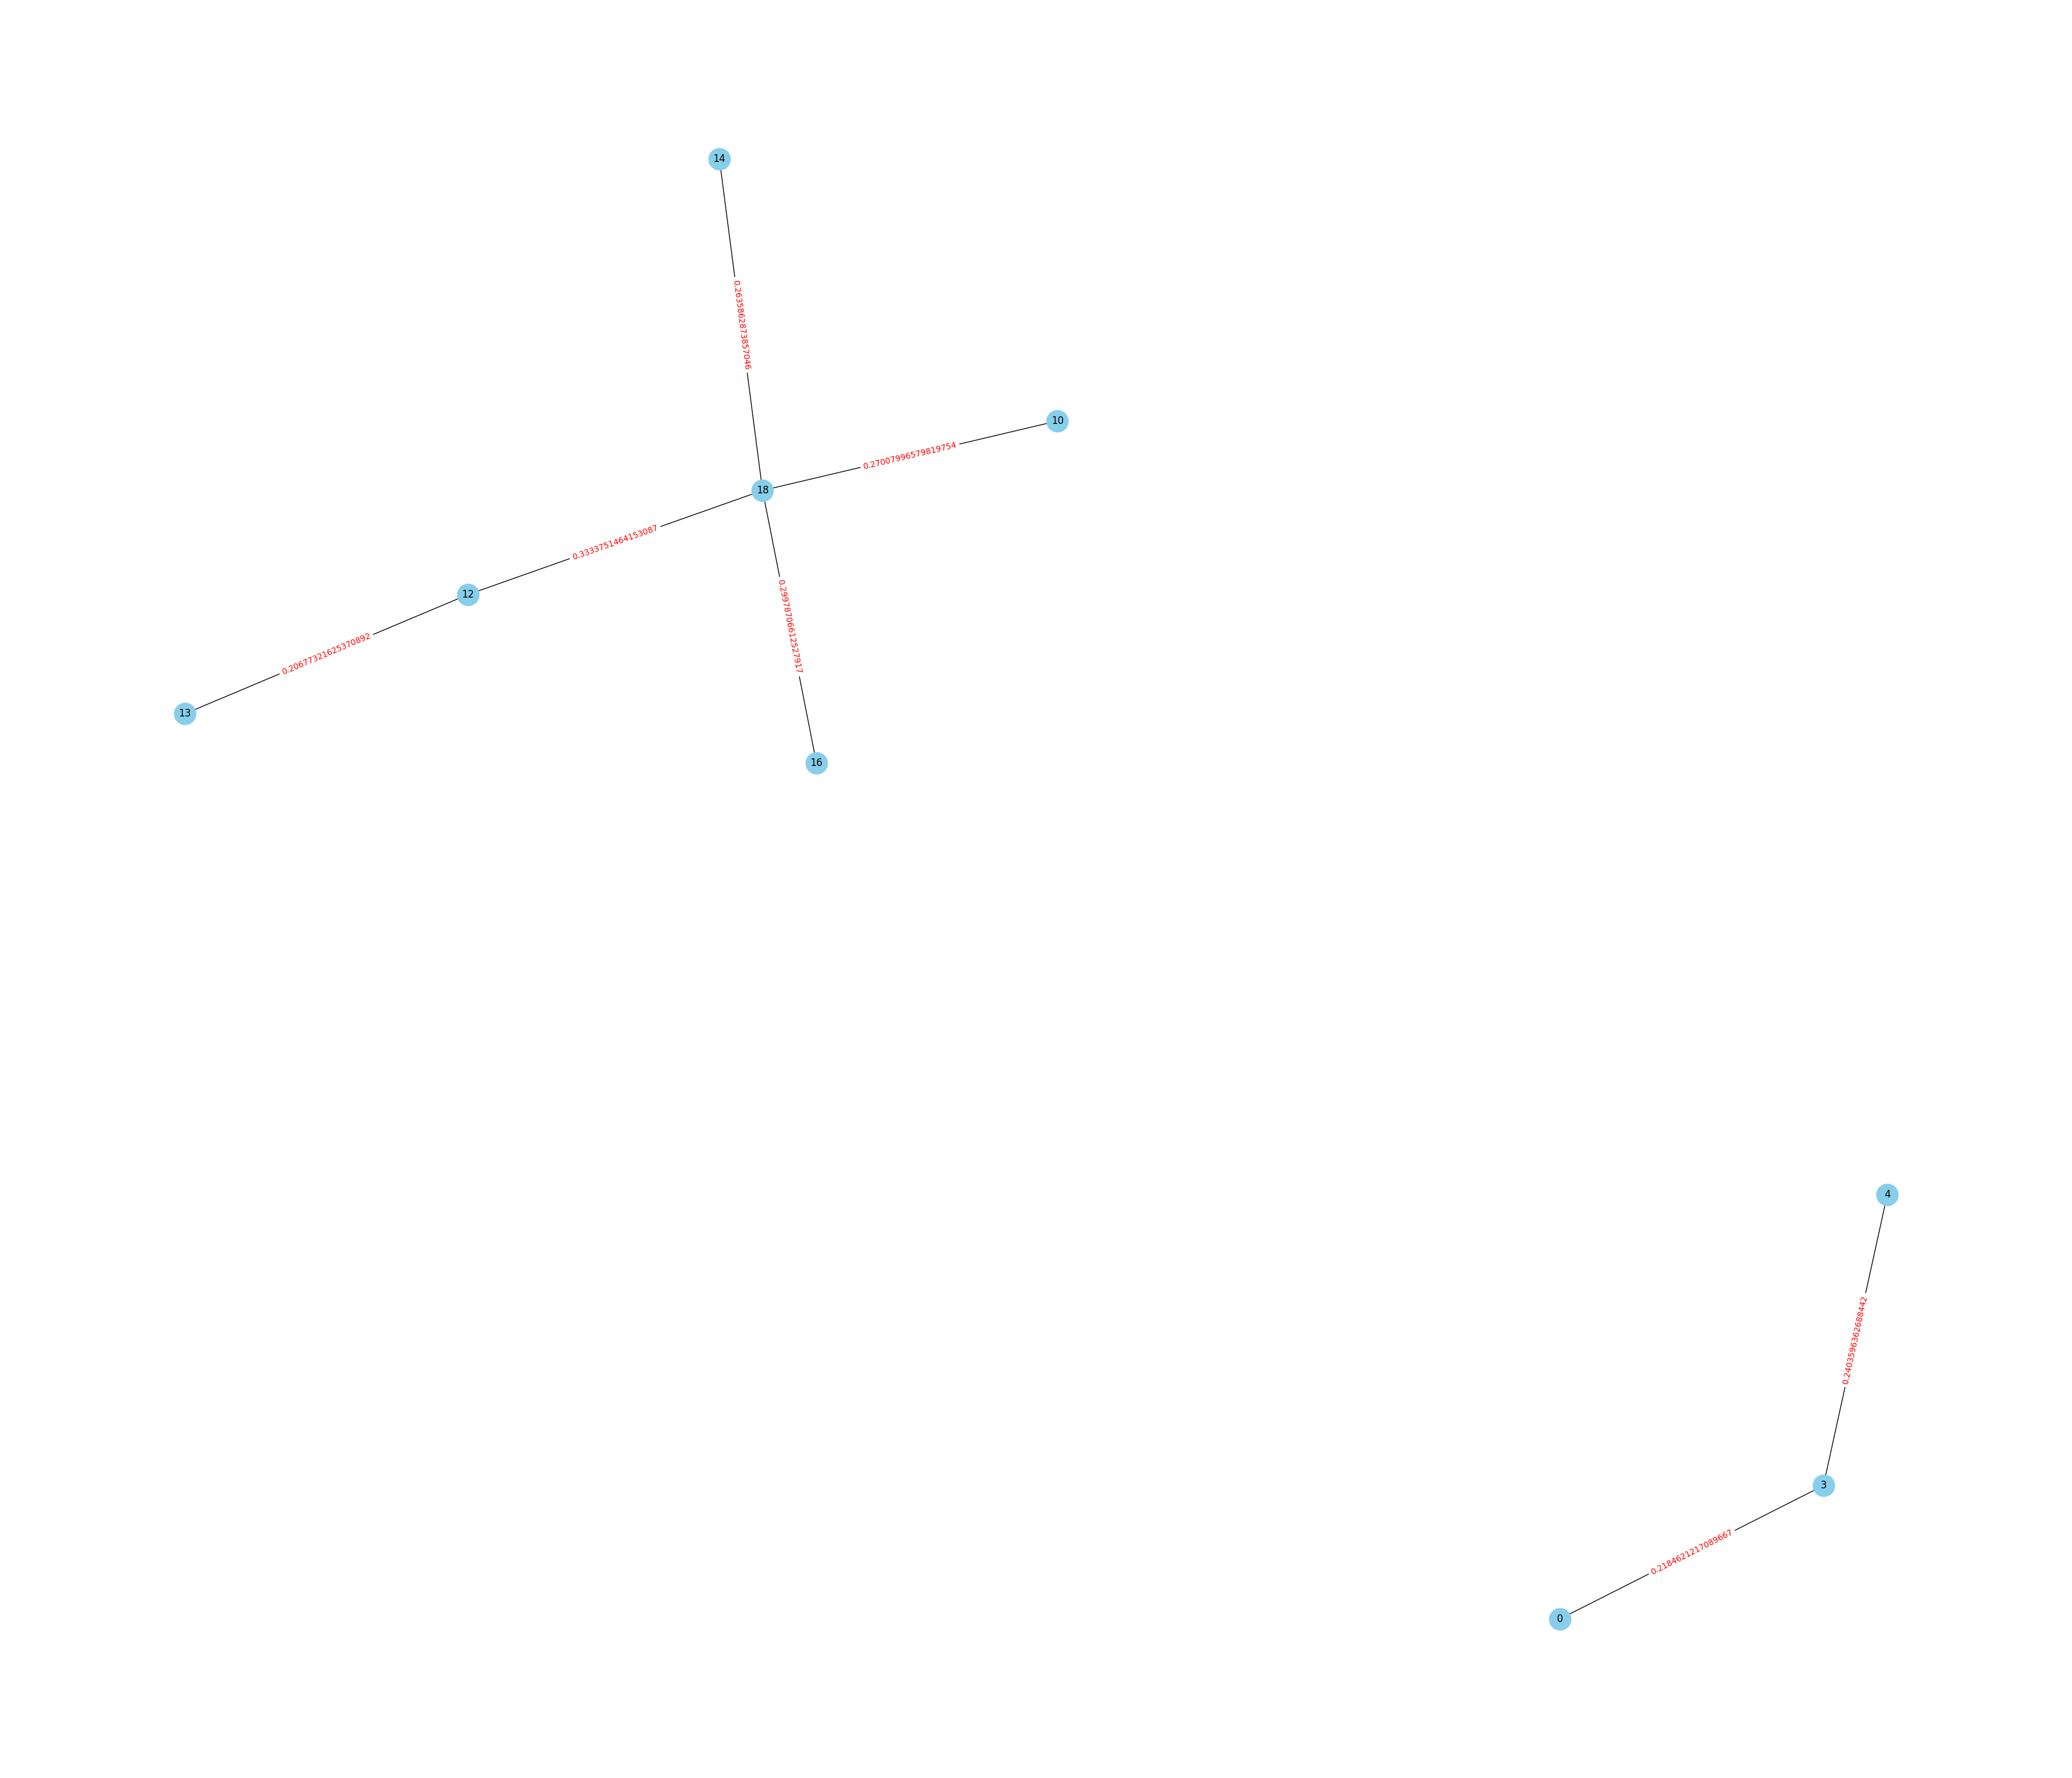

In [ ]:
plot_graph(G)

In [ ]:
df["Summary"] = df.apply(lambda row : summarization(row['Tokenizing'], index=row.name+1, k=7, show_centrality=True)[0], axis=1)

Nilai Closeness Centrality Dokumen Ke - 1 : {0: 0.3888888888888889, 1: 0.34146341463414637, 3: 0.32558139534883723, 6: 0.4, 9: 0.28, 4: 0.25, 5: 0.22950819672131148, 8: 0.1891891891891892, 18: 0.3888888888888889, 10: 0.2857142857142857, 12: 0.2978723404255319, 13: 0.23333333333333334, 14: 0.2978723404255319, 15: 0.23333333333333334, 16: 0.2857142857142857}
Nilai Closeness Centrality Dokumen Ke - 2 : {0: 0.6153846153846154, 1: 0.4444444444444444, 3: 0.47058823529411764, 6: 0.5, 7: 0.6153846153846154, 2: 0.32, 8: 0.4444444444444444, 4: 0.3333333333333333, 5: 0.4}
Nilai Closeness Centrality Dokumen Ke - 3 : {0: 0.7142857142857143, 2: 0.5555555555555556, 3: 0.8333333333333334, 5: 0.7142857142857143, 1: 0.45454545454545453, 4: 0.5}
Nilai Closeness Centrality Dokumen Ke - 4 : {0: 0.6956521739130435, 1: 0.64, 2: 0.64, 3: 0.64, 7: 0.6666666666666666, 9: 0.5925925925925926, 10: 0.5161290322580645, 11: 0.47058823529411764, 13: 0.47058823529411764, 15: 0.5333333333333333, 16: 0.47058823529411764,

In [ ]:
new_df = df[["Summary", "Kategori"]]
new_df

,Summary,Kategori
0,[berita seputar israel dan isu terkini di tana...,nasional
1,[jakarta ketua komisi pemberantasan korupsi k...,nasional
2,[dia pun berharap kalau firli bahuri bisa mund...,nasional
3,[surabaya empat korban luka berat dalam insid...,nasional
4,[jakarta polisi segera mengagendakan pemeriksa...,nasional
...,...,...
67,[jakarta polda metro jaya menetapkan ketua ko...,kriminal
68,[jakarta ketua komisi pemberantasan korupsi k...,kriminal
69,[terdakwa dua ruddian dan korban redho kemudia...,kriminal
70,[dia pun berharap kalau firli bahuri bisa mund...,kriminal


In [ ]:
new_df.to_csv('Data Berita Hasil Ringkasan.csv')

In [ ]:
df["Summary"][1]

['jakarta\xa0 ketua komisi pemberantasan korupsi kpk, firli bahuri terancam pidana penjara seumur hidup buntut ditetapkan jadi tersangka kasus dugaan pemerasan atau penerimaan gratifikasi dalam penanganan korupsi kementerian pertanian kementan 2021.',
 'firli bakal dikenakan pasal 12e atau pasal 12b atau pasal 11 uu 311999 yang telah diubah dengan uu 202001 tentang perubahan atas uu 311999 tentang pemberantasan tindak pidana korupsi juncto pasal 65 kuhp. untuk diketahui, polda metro jaya menaikkan status kasus dugaan pemerasan yang dilakukan pimpinan komisi pemberantasan korupsi kpk dalam penanganan kasus korupsi di kementerian pertanian kementan tahun 2021 ke penyidikan. menetapkan saudara fb selaku ketua kpk ri sebagai tersangka dalam perkara dugaan tindak pidana korupsi berupa pemerasan atau penerimaan gratifikasi, katanya. sebagaimana yang dimaksud ayat 1, dipidana seumur hidup atau pidana penjara paling singkat empat tahun dan paling lama 20 tahun. dalam rentetan pasal berlapis it

In [ ]:
df["Summary"] = df["Summary"].apply(lambda x: str(x) if isinstance(x, list) else x)

In [ ]:
non_string_indices = [idx for idx, item in enumerate(df["Summary"]) if not isinstance(item, str)]
print(non_string_indices)


[]


In [ ]:
vectorizer_summary = TfidfVectorizer()
X_summary = vectorizer_summary.fit_transform(df["Summary"]).toarray()
y = df["Kategori"]

In [ ]:
X_train_summary, X_test_summary, y_train_summary, y_test_summary = train_test_split(X_summary, y, test_size=0.3, random_state=42)

In [ ]:
# Inisialisasi model Naive Bayes Gaussian
gnb_summary = GaussianNB()

# Melatih model menggunakan data latih
gnb_summary.fit(X_train_summary, y_train_summary)

# Membuat prediksi pada data uji
y_pred_gnb_summary = gnb_summary.predict(X_test_summary)

In [ ]:
# Mengukur kinerja model dengan menghitung akurasi atau metrik lain yang relevan
accuracy = accuracy_score(y_test_summary, y_pred_gnb_summary)
print(f'Akurasi: {accuracy}')

Akurasi: 0.5454545454545454


In [ ]:
report = classification_report(y_test_summary, y_pred_gnb_summary)
print(f'Report Klasifikasi:\n{report}')

Report Klasifikasi:
              precision    recall  f1-score   support

    kriminal       0.71      0.83      0.77         6
    nasional       0.50      0.22      0.31         9
     politik       0.45      0.71      0.56         7

    accuracy                           0.55        22
   macro avg       0.56      0.59      0.54        22
weighted avg       0.54      0.55      0.51        22



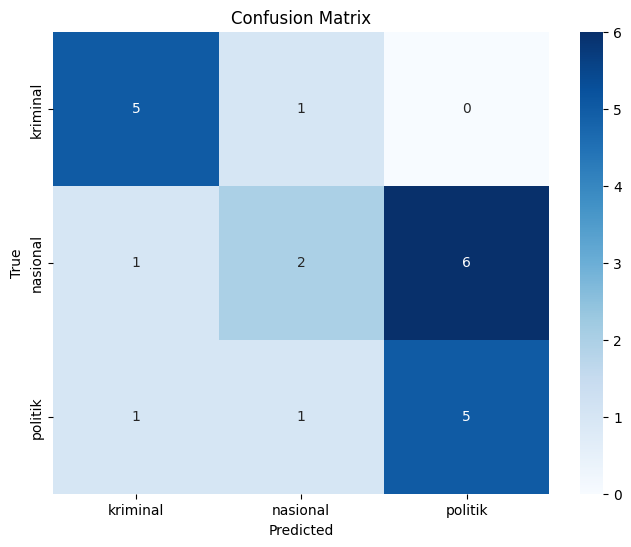

In [ ]:
def plot_confusion_matrix(cm):
  # Membuat plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=gnb_summary.classes_, yticklabels=gnb_summary.classes_)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

cm = confusion_matrix(y_test_summary, y_pred_gnb_summary)
plot_confusion_matrix(cm)

In [ ]:
new_data = ["Sebuah tim peneliti, yang dipimpin oleh mahasiswa doktoral Institute of Agricultural Engineering, University of Bonn, Jerman Sonja Hillemacher dan Dr. Inga Tiemann, telah melakukan penelitian ilmiah selama bertahun-tahun terhadap perilaku ayam di depan cermin. Ide bereksperimen dengan ayam datang dari para ilmuwan tersebut bersama guru besar Biopsikologi dari Departemen Biopsikologi di Universitas Ruhr, Onur Güntürkün. Filosofi penelitian ini bermula dari sebuah pertanyaan terkait 'Apakah hewan dapat mengenali dirinya sendiri?,' kata Sonja Hillemacher. Penelitian ini pun bertujuan untuk menjawab pertanyaan apakah ayam mampu mengenali diri mereka sendiri ketika berinteraksi dengan cermin. Metode Pendekatan Perilaku Hewan Penelitian ini mengadopsi metode yang telah umum digunakan dalam uji cermin, yang dikenal sebagai 'mark test'. Dalam tes ini, tanda berwarna ditempatkan di tubuh hewan yang hanya dapat dikenali oleh individu tersebut ketika ia melihat dirinya sendiri di cermin. Apabila hewan tersebut mulai memeriksa atau meraba area tubuhnya yang ditandai di depan cermin, itu menunjukkan bahwa hewan telah mengenali wujudnya sebagai dirinya sendiri. Namun, tes ini tidak selalu berhasil, di mana sebagian hewan yang diyakini sadar diri, tidak memperhatikan cermin. Mungkin, karena mereka merasa tidak nyaman dalam lingkungan percobaan 'buatan'? Penelitian ini mencoba mendekati eksperimen ini dengan mempertimbangkan perilaku alami ayam yang relevan secara ekologis. 'Beberapa ayam, terutama ayam jantan, memperingatkan sesamanya melalui panggilan khusus ketika ada predator -- seperti burung pemangsa atau rubah - - muncul,' kata Güntürkün. Sebaliknya jika ayam jago berhadapan dengan predatornya sendirian, biasanya mereka akan berdiam diri agar tidak menarik perhatian predator itu sendiri dan menjadi korban. 'Seruan peringatan adalah perilaku sempurna untuk diintegrasikan ke dalam tes kesadaran diri yang lebih relevan secara ekologis,' tambah biopsikolog tersebut. Uji Coba dengan Melepas Burung Pemangsa Pertama, penelitian ini memeriksa apakah ayam jantan benar-benar mengeluarkan panggilan alarm saat berhadapan dengan spesies dan tetap diam saat sendirian. Ilmuwan membangun tempat uji coba khusus yang memisahkan dua area di mana ayam jantan dapat melihat satu sama lain. Setelah itu, seekor burung pemangsa pun dilepaskan di langit-langit sebuah area. Dengan melibatkan 58 ekor ayam jantan, setiap ayamnya mengalami proses pengulangan penelitian sebanyak tiga kali untuk memvalidasi hasil statistik. Hasilnya pun menunjukkan bahwa ayam jantan mengeluarkan 77 panggilan alarm saat berhadapan dengan ayam jantan lain, tetapi hanya 17 panggilan ketika ayam jantan itu sendiri. Dengan begitu, ini menunjukkan bahwa sebagian besar ayam jantan sangat waspada saat menghadapi sesamanya ketika predator terlihat. Uji Coba dengan Cermin Langkah selanjutnya adalah menempatkan cermin di antara dua kompartemen, bukan di dalam kisi-kisi. Dalam proses penelitian ini, para peneliti menjalankannya tiga kali dengan masing-masing hewan. Hasilnya, hanya 25 panggilan alarm yang dikeluarkan selama 174 percobaan. Hasil ini mendukung gagasan bahwa ayam jantan mungkin mengenali dirinya sendiri dalam bayangan cerminnya. Namun, masih diperlukan penelitian lebih lanjut untuk memahami apakah hewan-hewan tersebut melihat bayangan diri mereka sebagai entitas yang sama atau sebagai binatang asing yang meniru perilaku mereka sendiri. Penelitian ini menunjukkan bahwa uji tanda cermin yang mengintegrasikan perilaku hewan ke dalam konteks yang lebih relevan secara ekologis memberikan hasil yang lebih dapat diandalkan."]
new_data_summary, G = summarization(tokenizer(new_data[0]), k=5)
new_data_summary

['dalam tes ini, tanda berwarna ditempatkan di tubuh hewan yang hanya dapat dikenali oleh individu tersebut ketika ia melihat dirinya sendiri di cermin. hasil ini mendukung gagasan bahwa ayam jantan mungkin mengenali dirinya sendiri dalam bayangan cerminnya. apabila hewan tersebut mulai memeriksa atau meraba area tubuhnya yang ditandai di depan cermin, itu menunjukkan bahwa hewan telah mengenali wujudnya sebagai dirinya sendiri. hasilnya pun menunjukkan bahwa ayam jantan mengeluarkan 77 panggilan alarm saat berhadapan dengan ayam jantan lain, tetapi hanya 17 panggilan ketika ayam jantan itu sendiri. penelitian ini pun bertujuan untuk menjawab pertanyaan apakah ayam mampu mengenali diri mereka sendiri ketika berinteraksi dengan cermin.']

In [ ]:
cleaned_new_data_summary = [str(doc) for doc in new_data_summary]

In [ ]:
tfidf_Xnew_summary = vectorizer_summary.transform(cleaned_new_data_summary).toarray()
tfidf_Xnew_summary

array([[0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
pred_gnb_summary = gnb_summary.predict(tfidf_Xnew_summary)
pred_gnb_summary[0]

'politik'

In [ ]:
joblib.dump(gnb_summary, 'modelnbsummary.pkl')

['modelnbsummary.pkl']

In [ ]:
# Inisialisasi model Naive Bayes Gaussian
svm_summary = SVC()

# Melatih model menggunakan data latih
svm_summary.fit(X_train_summary, y_train_summary)

# Membuat prediksi pada data uji
y_pred_svm_summary = svm_summary.predict(X_test_summary)

In [ ]:
# Mengukur kinerja model dengan menghitung akurasi atau metrik lain yang relevan
accuracy = accuracy_score(y_test_summary, y_pred_svm_summary)
print(f'Akurasi: {accuracy}')

Akurasi: 0.5454545454545454


In [ ]:
pred_svm_summary = svm_summary.predict(tfidf_Xnew_summary)
pred_svm_summary[0]

'politik'

In [ ]:
joblib.dump(svm_summary, 'modelSVMsummary.pkl')

['modelSVMsummary.pkl']